Remarks
- Added initial cell to reload modules automatically 
- In `FormatData` definition
  - file paths are hardcoded -> either provide it as a fct parameter or mention in readme how names should be formatted
  - ~~the line `self.adata.obs = metadata_df` rewrites `self.adata.obs_names` as well!! --> I don't know if this should later be fixed?~~
- In readme
  - in `FormatData` documentation, `.x_train` and `.x_test` are said to be DataFrames but I think they're arrays
  - `.selected_genes` are explained twice (and are the same info as `.genes`)
  - in `binary_pso` documentation, `current_data` is said to be a dataframe, but I think it is a `FormatData` object
- PredAnnModel didn't use to scale data??? <- check this!! TODO
- !!! I think results aren't deterministic/reproducible!

# Single Cell Walkthrough

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [ ]:
from PAGEpy import plot_functions
from PAGEpy import pso as pso
from PAGEpy.dataset_class import GeneExpressionDataset
from PAGEpy.models import AdvancedNN, SimpleNN, TrainingConfig
import pickle
import pandas as pd
from PAGEpy import PAGEpy_utils

# memory growth is enabled for for the gpu
PAGEpy_utils.init_cuda()

## Create Dataset
Dataset has 2000 gene features, selected using `HVG` (can also use differential expression analysis `Diff`; leave empty to use whole gene list given by `genes_pattern`).

In [ ]:
n_hvg_input_features = 2000

# TODO: instead of file patterns, use whole filenames
current_data = GeneExpressionDataset(
    data_dir="../../HIVdata/",
    counts_pattern="*counts.mtx",
    barcodes_pattern="*barcodes.txt",
    # I think here it's possible to set already processed gene list:
    genes_pattern="*genes.txt",
    metadata_pattern="*infection_status.csv",
    gene_selection="HVG",
    pval_correction="benjamini-hochberg",
    hvg_count=n_hvg_input_features,
    features_out_filename="feature_set.pkl",
    train_samples_out_filename="train_samples.txt",
)

AnnData object successfully constructed.
AnnData object counts are now normalized.
Training samples: 4208, Test samples: 1053
Selected 2000 features using HVG


In [4]:
# the selected genes can be loaded from the local directory, however, they are
# also an attribte of the GeneExpressionDataset object
genes_path = "feature_set.pkl"

with open(genes_path, "rb") as f:
    current_genes = pickle.load(f)
print(f"Loaded {len(current_genes)} genes as 'current_genes'")

Loaded 2000 genes as 'current_genes'


## Initialize and train NN Model

Set NN model parameters

In [5]:
# retrieved default params used in Sean's code
config = TrainingConfig(
    report_frequency=1,
    auc_threshold=1,
    learning_rate=0.001)

training_params = {
    'n_epochs': 50,
    # 'n_epochs': 500,
    # 'batch_size': 512, # value used in pso script
    'batch_size': 64,  # original notebook (default val); not sure
    'seed': 42,
}

Train NN model before PSO

In [6]:
# Initialize NN model
# TODO: modify PredAnnModel to only create the model and not train it
initial_model = AdvancedNN(
    # initial_model = SimpleNN(
    n_input_features=n_hvg_input_features,
    config=config,
)

# Train model
train_history = initial_model.train(
    x_train=current_data.x_train,
    y_train=current_data.y_train,
    x_test=current_data.x_test,
    y_test=current_data.y_test,
    **training_params,
)

Model created with 2000 input features
Epoch 0: Adjusting learning rate to 0.005000
Epoch 10/50:
	Train Loss: 0.1586, AUC: 0.9862, Acc: 0.9363
	Test AUC: 0.9444, Acc: 0.8557
Epoch 20/50:
	Train Loss: 0.0554, AUC: 0.9978, Acc: 0.9808
	Test AUC: 0.9263, Acc: 0.8623
Epoch 30/50:
	Train Loss: 0.0224, AUC: 0.9998, Acc: 0.9874
	Test AUC: 0.9237, Acc: 0.8338
Epoch 40/50:
	Train Loss: 0.0186, AUC: 0.9999, Acc: 0.9924
	Test AUC: 0.9165, Acc: 0.8519
Epoch 50/50:
	Train Loss: 0.0154, AUC: 0.9999, Acc: 0.9945
	Test AUC: 0.9098, Acc: 0.8367


Max train accuracy: 1.00
Max train AUC: 1.00
Max test accuracy: 0.88
Max test AUC: 0.95


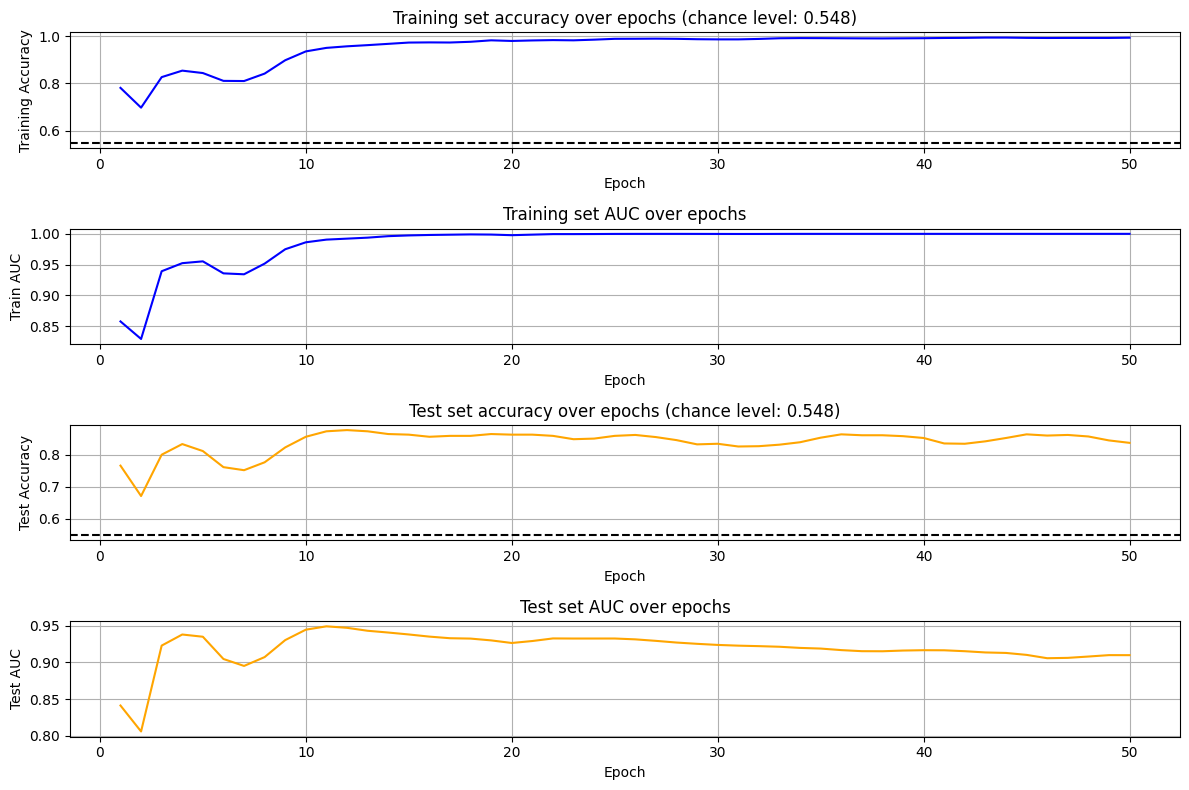

In [7]:
plot_functions.plot_model_history(
    model_history=train_history,
    report_frequency=initial_model.config.report_frequency,
    y_train=current_data.y_train,
    y_test=current_data.y_test,
    save_path=None
)

## Run binary PSO

In [8]:
# the pso algorithm can be use to optimze the solution
best_solution, best_fitness = pso.run_binary_pso(
    input_data=current_data,
    feature_names=current_genes,
    # pop_size=200,
    pop_size=5,
    # n_generations=15,
    n_generations=2,
    w=1,
    c1=2,
    c2=1.5,
    # n_reps=4,
    n_reps=1,
    # frequent_reporting=False,
    verbose=True,
    adaptive_metrics=False
)

Training particle 1, generation 1 with 976 genes
Model created with 976 input features
  Fold 1/5: AUC = 0.9151
Model created with 976 input features
  Fold 2/5: AUC = 0.8964
Model created with 976 input features
  Fold 3/5: AUC = 0.9120
Model created with 976 input features
  Fold 4/5: AUC = 0.9004
Model created with 976 input features
  Fold 5/5: AUC = 0.9108
All folds completed for particle 1, generation 1
Average final test AUC value: 0.907
Total time: 12.12908411026001 seconds
Training particle 2, generation 1 with 989 genes
Model created with 989 input features
  Fold 1/5: AUC = 0.9096
Model created with 989 input features
  Fold 2/5: AUC = 0.9033
Model created with 989 input features
  Fold 3/5: AUC = 0.8911
Model created with 989 input features
  Fold 4/5: AUC = 0.8944
Model created with 989 input features
  Fold 5/5: AUC = 0.8962
All folds completed for particle 2, generation 1
Average final test AUC value: 0.899
Total time: 12.751675128936768 seconds
Training particle 3, gene

In [9]:
# the results of pso optimizatoin can be monitored
loaded_fitness_scores = pd.read_pickle("pso_fitness_scores.pkl")
loaded_particle_history = pd.read_pickle("pso_particle_history.pkl")

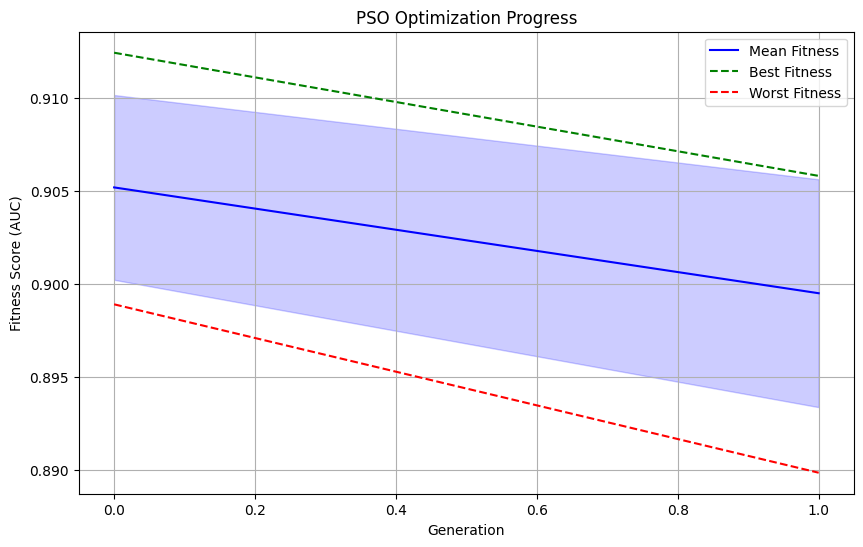

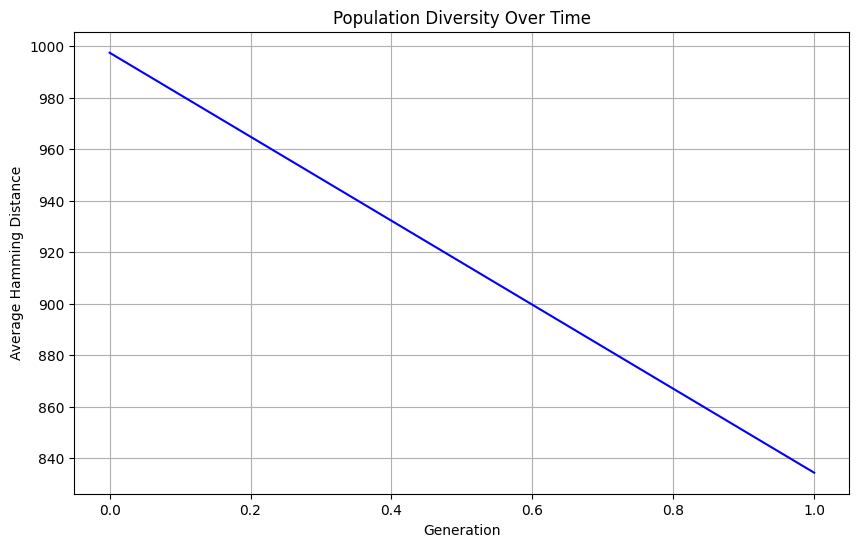

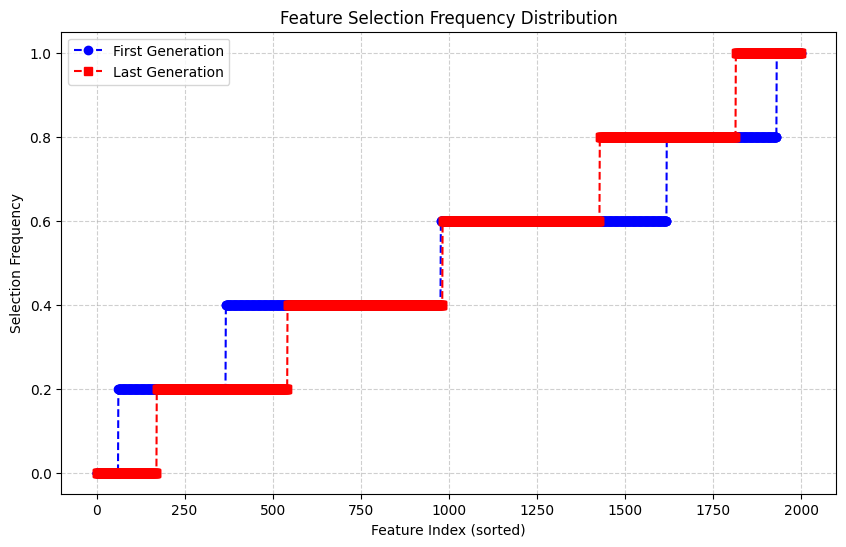

In [10]:
plot_functions.plot_pso_fitness_evolution(loaded_fitness_scores)
plot_functions.plot_population_diversity(loaded_particle_history)
plot_functions.plot_feature_selection_frequency(
    loaded_particle_history)

## Initialize and train improved NN Model

In [11]:
# the optimised solution is saved locally, however, the returned varible from the binary_pso function can also be passed to the model (see below)
# pso_genes = [item for item, m in zip(current_genes, best_solution) if m == 1]

# othervise just load the locally stored result file

# Load the saved genes list
with open("pso_selected_genes.pkl", "rb") as f:
    pso_genes = pickle.load(f)

In [12]:
# now use this gene list to train a new model, which you can then evaluate
n_pso_input_features = len(pso_genes)

improved_model = AdvancedNN(
    # improved_model = SimpleNN(
    n_input_features=n_pso_input_features,
    config=config,
)

# select feature subset and scale data
x_train, x_test, y_train, y_test = current_data.get_scaled_feature_subset(
    feature_subset=pso_genes
)

# Train model
improved_train_history = improved_model.train(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    **training_params,
)

Model created with 1001 input features
Epoch 0: Adjusting learning rate to 0.005000
Epoch 10/50:
	Train Loss: 0.2002, AUC: 0.9784, Acc: 0.8812
	Test AUC: 0.9220, Acc: 0.7863
Epoch 20/50:
	Train Loss: 0.0782, AUC: 0.9957, Acc: 0.9765
	Test AUC: 0.9059, Acc: 0.8386
Epoch 30/50:
	Train Loss: 0.0422, AUC: 0.9998, Acc: 0.9926
	Test AUC: 0.9138, Acc: 0.8414
Epoch 40/50:
	Train Loss: 0.0213, AUC: 0.9999, Acc: 0.9936
	Test AUC: 0.9051, Acc: 0.8452
Epoch 50/50:
	Train Loss: 0.0124, AUC: 1.0000, Acc: 0.9964
	Test AUC: 0.9031, Acc: 0.8424


Max train accuracy: 1.00
Max train AUC: 1.00
Max test accuracy: 0.86
Max test AUC: 0.92


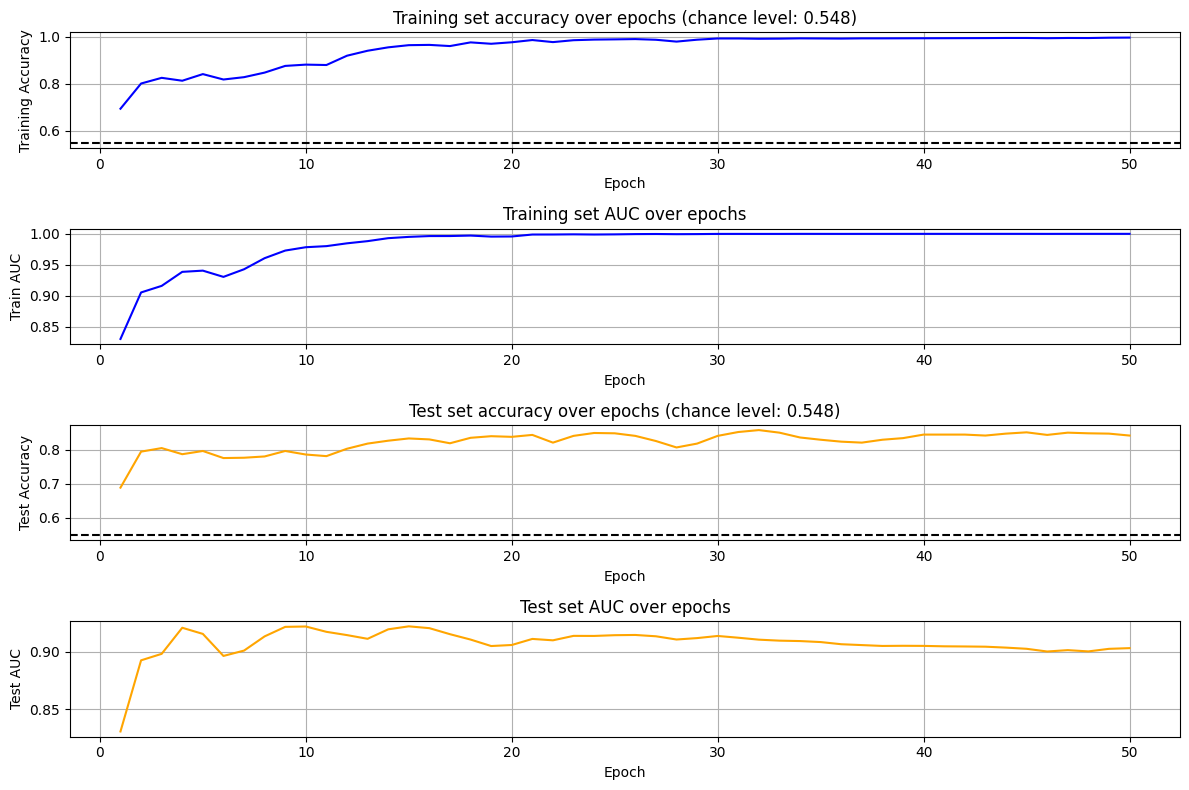

In [13]:
plot_functions.plot_model_history(
    model_history=improved_train_history,
    report_frequency=improved_model.config.report_frequency,
    y_train=y_train,
    y_test=y_test,
    save_path=None
)